In [3]:
import pandas as pd
import requests
import numpy as np
from numpy.random import random as rand
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data.sampler import WeightedRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

### Load in online available dataset

In [203]:
# Retrieved from https://www.kaggle.com/iamhungundji/data-generation/output
data = pd.read_csv("Cleaned-Data.csv")
data = data.drop(['Country'],axis=1)
data = data.rename(columns={'None_Sympton':'No_Symptom'})
data

,Fever,Tiredness,Dry-Cough,Difficulty-in-Breathing,Sore-Throat,No_Symptom,Pains,Nasal-Congestion,Runny-Nose,Diarrhea,...,Gender_Female,Gender_Male,Gender_Transgender,Severity_Mild,Severity_Moderate,Severity_None,Severity_Severe,Contact_Dont-Know,Contact_No,Contact_Yes
0,1,1,1,1,1,0,1,1,1,1,...,0,1,0,1,0,0,0,0,0,1
1,1,1,1,1,1,0,1,1,1,1,...,0,1,0,1,0,0,0,0,1,0
2,1,1,1,1,1,0,1,1,1,1,...,0,1,0,1,0,0,0,1,0,0
3,1,1,1,1,1,0,1,1,1,1,...,0,1,0,0,1,0,0,0,0,1
4,1,1,1,1,1,0,1,1,1,1,...,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316795,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
316796,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,1,0,0
316797,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
316798,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0


In [204]:
data['Status'] = 0

In [205]:
data = data.sample(n=20000, random_state=12)
data

,Fever,Tiredness,Dry-Cough,Difficulty-in-Breathing,Sore-Throat,No_Symptom,Pains,Nasal-Congestion,Runny-Nose,Diarrhea,...,Gender_Male,Gender_Transgender,Severity_Mild,Severity_Moderate,Severity_None,Severity_Severe,Contact_Dont-Know,Contact_No,Contact_Yes,Status
106301,0,1,1,1,1,0,1,0,0,0,...,0,1,0,1,0,0,1,0,0,0
286524,0,0,1,1,0,0,0,0,1,1,...,1,0,1,0,0,0,0,0,1,0
26024,0,1,1,1,1,0,1,1,1,0,...,1,0,0,0,0,1,1,0,0,0
40493,1,1,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
92055,0,0,1,1,1,0,0,1,1,1,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112529,1,0,0,0,0,0,0,1,1,0,...,0,1,0,1,0,0,1,0,0,0
132024,0,1,0,0,0,0,1,1,0,0,...,0,1,1,0,0,0,0,0,1,0
86094,0,0,0,1,1,0,1,1,0,0,...,0,0,0,0,0,1,0,0,1,0
292442,0,1,1,0,0,0,0,1,1,0,...,1,0,1,0,0,0,1,0,0,0


### Construct test values

Contribution probabilities for each part of the dataset (these are preset for simulation purposes):
* Fever: p=0.95
* Tiredness: p=0.8
* Dry-Cough: p=0.8
* Difficulty-in-Breathing: p=0.95
* Sore-Throat: p=0.8
* No_Symptom: p=0.2
* Pains: p=0.5
* Nasal-Congestion: p=0.5
* Runny-Nose: p=0.5
* Diarrhea: p=0.5
* None_Experiencing: p=0.2 (split 50/50 with No_Symptom)
* Age_0-9: p=0.4
* Age_10-19: p=0.3
* Age_20-24: p=0.4
* Age_25-59: p=0.6
* Age_60+: p=0.7
* Gender_Female: p=0.4
* Gender_Male: p=0.6
* Gender_Transgender: p=0.5
* Severity_Mild: p=0.4
* Severity_Moderate: p=0.6
* Severity_None: p=0.3
* Severity_Severe: p=0.8
* Contact_Dont-Know: p=0.5
* Contact_No: p=0.2
* Contact_Yes: p=0.8

In [206]:
# Establish a seed for reproducability
np.random.seed(15)

In [207]:
for i, _ in data.iterrows():
    total = 0
    
    if data.loc[i,'Fever'] == 1:
        total += int(np.random.choice(a=range(2), size=1, p=[0.1, 0.9]))
        
    if data.loc[i,'Tiredness'] == 1:
        total += int(np.random.choice(a=range(2), size=1, p=[0.3, 0.7]))
    
    if data.loc[i,'Dry-Cough'] == 1:
        total += int(np.random.choice(a=range(2), size=1, p=[0.2, 0.8]))
        
    if data.loc[i,'Difficulty-in-Breathing'] == 1:
        total += int(np.random.choice(a=range(2), size=1, p=[0.1, 0.9]))
        
    if data.loc[i,'Sore-Throat'] == 1:
        total += int(np.random.choice(a=range(2), size=1, p=[0.3, 0.7]))
        
    if data.loc[i,'No_Symptom'] == 1 or data.loc[i, 'None_Experiencing'] == 1:
        total += int(np.random.choice(a=range(2), size=1, p=[0.8, 0.2]))
    
    if data.loc[i,'Pains'] == 1:
        total += int(np.random.choice(a=range(2), size=1, p=[0.6, 0.4]))
    
    if data.loc[i,'Nasal-Congestion'] == 1:
        total += int(np.random.choice(a=range(2), size=1, p=[0.6, 0.4]))
        
    if data.loc[i,'Runny-Nose'] == 1:
        total += int(np.random.choice(a=range(2), size=1, p=[0.6, 0.4]))
        
    if data.loc[i,'Age_0-9'] == 1:
        total += int(np.random.choice(a=range(2), size=1, p=[0.6, 0.4]))
        
    if data.loc[i,'Age_10-19'] == 1:
        total += int(np.random.choice(a=range(2), size=1, p=[0.7, 0.3]))
        
    if data.loc[i,'Age_20-24'] == 1:
        total += int(np.random.choice(a=range(2), size=1, p=[0.7, 0.3]))
    
    if data.loc[i,'Age_25-59'] == 1:
        total += int(np.random.choice(a=range(2), size=1, p=[0.5, 0.5]))
    
    if data.loc[i,'Age_60+'] == 1:
        total += int(np.random.choice(a=range(2), size=1, p=[0.3, 0.7]))
    
    if data.loc[i,'Gender_Female'] == 1:
        total += int(np.random.choice(a=range(2), size=1, p=[0.6, 0.4]))
    
    if data.loc[i,'Gender_Male'] == 1:
        total += int(np.random.choice(a=range(2), size=1, p=[0.4, 0.6]))
    
    if data.loc[i,'Gender_Transgender'] == 1:
        total += int(np.random.choice(a=range(2), size=1, p=[0.5, 0.5]))
    
    if data.loc[i,'Severity_Mild'] == 1:
        total += int(np.random.choice(a=range(2), size=1, p=[0.6, 0.4]))
        
    if data.loc[i,'Severity_Moderate'] == 1:
        total += int(np.random.choice(a=range(2), size=1, p=[0.4, 0.6]))    
    
    if data.loc[i,'Severity_None'] == 1:
        total += int(np.random.choice(a=range(2), size=1, p=[0.7, 0.3]))
        
    if data.loc[i,'Severity_Severe'] == 1:
        total += int(np.random.choice(a=range(2), size=1, p=[0.2, 0.8]))
        
    if data.loc[i,'Contact_Dont-Know'] == 1:
        total += int(np.random.choice(a=range(2), size=1, p=[0.5, 0.5]))
    
    if data.loc[i,'Contact_No'] == 1:
        total += int(np.random.choice(a=range(2), size=1, p=[0.8, 0.2]))
    
    if data.loc[i,'Contact_Yes'] == 1:
        total += int(np.random.choice(a=range(2), size=1, p=[0.1, 0.9]))
    
    if total > 7:
        data.loc[i, 'Status'] = 1
    else:
        data.loc[i, 'Status'] = 0

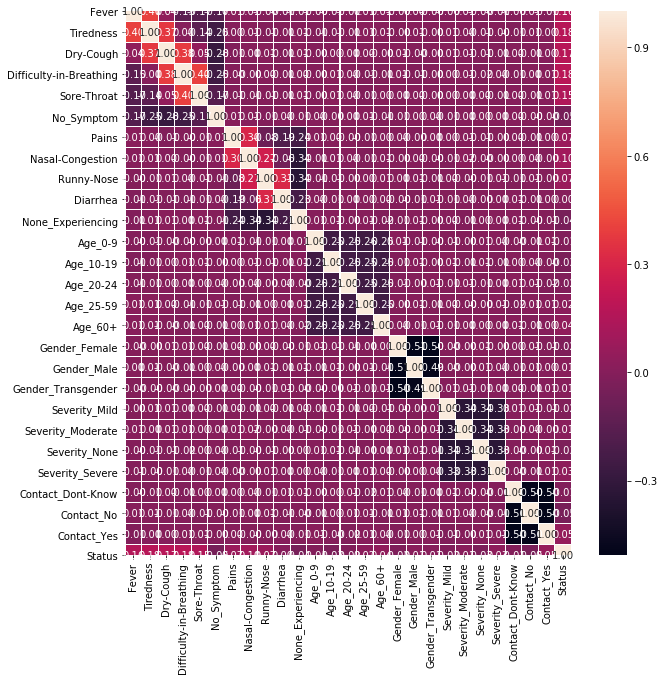

In [208]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(), annot=True, linewidths=0.05, fmt='.2f')
plt.show()

### Establish model parameters

In [377]:
epochs = 20
batch_size = 50

### Load the data

In [378]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

In [379]:
X = data.iloc[:,0:-1].to_numpy()
Y = data.iloc[:,-1].to_numpy()

In [380]:
#Split the test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42,stratify=Y)
print ('target train: {}/{}'.format(len(np.where(y_train==0)[0]),
                                   len(np.where(y_train==1)[0])))

#Find the weights for each of the samples
class_sample_count = np.array([len(np.where(y_train==t)[0]) for t in np.unique(y_train)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])

samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

trainDataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train.astype(int)))
validDataset = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test.astype(int)))

train_loader = DataLoader(dataset = trainDataset, batch_size=batch_size, 
                                           num_workers=1, sampler = sampler)
test_loader = DataLoader(dataset = validDataset, batch_size=batch_size, 
                                          shuffle=False, num_workers=1) 

for i, (inputs, target) in enumerate(train_loader):
    print ("batch index {}, 0/1: {}/{}".format(
        i, len(np.where(target.numpy()==0)[0]), len(np.where(target.numpy()==1)[0])))

target train: 12864/536
batch index 0, 0/1: 26/24
batch index 1, 0/1: 25/25
batch index 2, 0/1: 31/19
batch index 3, 0/1: 25/25
batch index 4, 0/1: 27/23
batch index 5, 0/1: 27/23
batch index 6, 0/1: 31/19
batch index 7, 0/1: 33/17
batch index 8, 0/1: 30/20
batch index 9, 0/1: 27/23
batch index 10, 0/1: 28/22
batch index 11, 0/1: 25/25
batch index 12, 0/1: 23/27
batch index 13, 0/1: 19/31
batch index 14, 0/1: 25/25
batch index 15, 0/1: 26/24
batch index 16, 0/1: 25/25
batch index 17, 0/1: 25/25
batch index 18, 0/1: 27/23
batch index 19, 0/1: 24/26
batch index 20, 0/1: 25/25
batch index 21, 0/1: 24/26
batch index 22, 0/1: 28/22
batch index 23, 0/1: 26/24
batch index 24, 0/1: 31/19
batch index 25, 0/1: 23/27
batch index 26, 0/1: 31/19
batch index 27, 0/1: 27/23
batch index 28, 0/1: 24/26
batch index 29, 0/1: 28/22
batch index 30, 0/1: 25/25
batch index 31, 0/1: 24/26
batch index 32, 0/1: 25/25
batch index 33, 0/1: 25/25
batch index 34, 0/1: 23/27
batch index 35, 0/1: 28/22
batch index 36

### Baseline Metric: Logistic Regression

In [381]:
class binaryClassifier(nn.Module):
    """
        A general classifier that can use multiple activation functions, or none at all.
        By making the activation function we use an argument during initialization we don't
        have to make a different function every time we want to change up the activation
        function. We want to also have the option of having no activation function, so the 
        model behaves just like a linear regression without an activation function.
    """
    # The class constructor defines the parameters (ie layers) of the neural network
    # add an init function which allows us to pass in arbitrary activation functions
    # and defaults to None.
    
    
    #### your code here ####
    def __init__(self, nFeats, activation = None):
    #### end your code ####
    
    
        super(binaryClassifier, self).__init__()
        # What type of parameters do we need to add?
        self.linear = nn.Linear(in_features = nFeats, out_features = 1)
        # Do not remove the line below. It allows the model to learn by initializing small weights
        self.linear.weight= torch.nn.init.xavier_uniform_(self.linear.weight, gain = 0.001)
        
        
        # Store the activation function in our object
        #### your code here ####
        self.act_f = activation
        #### end your code ####
        
        
        
    def forward(self, x):
        # Write a forward pass function which optionally uses the activation function
        #### your code here ####
        if (self.act_f == None):
            return self.linear(x)
        else:
            return self.act_f(self.linear(x))
        #### end your code ####

### Defining our neural network

In [382]:
class FFNN(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim=1, act_fn="sigmoid", apply_dropout=False):
        super(FFNN, self).__init__()
        
        # Linear Functions
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
        #Number of hidden layers
        self.hidden_dim = hidden_dim
        
        # Activation function
        self.act_fn = act_fn
        
        #Consider use of dropout
        self.dropout = None
        if apply_dropout:
            self.dropout = nn.Dropout(0.5)
        
    
    # Here's where we connect all the layers together
    def forward(self, x):
        
        #Set activation function from user input
        act_fn = None
        if self.act_fn == 'sigmoid':
            act_fn = F.torch.sigmoid
        elif self.act_fn == 'tanh':
            act_fn = F.torch.tanh
        elif self.act_fn == 'relu':
            act_fn = F.torch.relu
            
        #Pass through the layers
        out = act_fn(self.fc1(x))
        out = act_fn(self.fc2(out))
        
        #Apply dropout only before final layer
        if self.dropout != None:
            out = self.dropout(out)
        
        #Output layer
        out = self.fc3(out)
        
        return out

## Defining the training and validation steps

In [383]:
def train_model(model, n_epochs, learning_rate):    
    iteration = 0
    Y_v = 0
    Y_v_hat = 0
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    criterion = nn.BCEWithLogitsLoss()
    for epochs in range(n_epochs):
        #outs = []
        model.train()
        
        for inputs, targets in train_loader:

            # Make sure they accumulate gradients!
            inputs.requires_grad = True
            #Ensure that targets are of type Float, not Long
            targets = targets.type_as(inputs)

            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            # Forward pass to get the output/logits
            output = model(inputs)

            # Calculate training Loss
            t_loss = criterion(output, targets.unsqueeze(1))
            t_losses.append(t_loss.detach().numpy())

            # Get gradients w.r.t. the parameters
            t_loss.backward()

            # Update the parameters
            optimizer.step()

            iteration += 1
            

            # Every 100 iterations, check up on how the model is doing, 
            # by printing the loss and the training accuracy on the held out data. 
            # Accuracy = (number of test statuses correctly identified) / (total number of statuses)
            if iteration % 100 == 0:
                # Calculate Accuracy         
                correct = 0
                total = 0
                
                model.eval()
                
                # Iterate through test dataset
                for inputs, targets in test_loader:
                    
                    # Load input with gradient accumulation capabilities
                    inputs.requires_grad = True
                    
                    #Ensure that targets are of type Float, not Long
                    targets = targets.type_as(inputs)

                    # Forward pass only to get logits/output
                    outputs = model(inputs)
                    
                    # Calculate validation loss
                    v_loss = criterion(output, targets.unsqueeze(1))
                    v_losses.append(v_loss.detach().numpy())

                    # Get predictions from the maximum value
                    predictions = output >= 0.0
                    #outs.append(predictions)

                    # Get the total number of labels
                    total += targets.size(0)

                    # Calculate the total correct predictions
                    overlap = predictions.eq(targets)
                    correct += (overlap == True).sum().item()

                accuracy = correct/total
                accuracies.append(accuracy)
                
                #For ROC curve
                Y_v = targets
                Y_v_hat = outputs

                # Print Loss
                print('Iteration: {}. Training Loss: {}. Validation Loss: {}. Accuracy: {}'
                      .format(iteration, t_loss.item(), v_loss.item() , accuracy))
                #print(outs)
    return Y_v, Y_v_hat

In [384]:
input_dim = X_train.shape[1]

In [385]:
baseline = binaryClassifier(input_dim)
baseline

binaryClassifier(
  (linear): Linear(in_features=26, out_features=1, bias=True)
)

In [386]:
accuracies = []
t_losses = []
v_losses = []
Y_v, Y_v_hat = train_model(baseline, epochs, learning_rate = 0.01)

Iteration: 100. Training Loss: 0.486995667219162. Validation Loss: 0.8103653192520142. Accuracy: 16.72
Iteration: 200. Training Loss: 0.45793941617012024. Validation Loss: 1.115891695022583. Accuracy: 19.48
Iteration: 300. Training Loss: 0.3877420723438263. Validation Loss: 1.0103368759155273. Accuracy: 20.4
Iteration: 400. Training Loss: 0.26934388279914856. Validation Loss: 0.9684010148048401. Accuracy: 25.0
Iteration: 500. Training Loss: 0.2936246991157532. Validation Loss: 1.2411807775497437. Accuracy: 22.24
Iteration: 600. Training Loss: 0.34131962060928345. Validation Loss: 1.0496137142181396. Accuracy: 22.24
Iteration: 700. Training Loss: 0.42674627900123596. Validation Loss: 1.0310711860656738. Accuracy: 25.92
Iteration: 800. Training Loss: 0.3545239269733429. Validation Loss: 1.4335955381393433. Accuracy: 19.48
Iteration: 900. Training Loss: 0.3129180073738098. Validation Loss: 1.3932561874389648. Accuracy: 17.64
Iteration: 1000. Training Loss: 0.48290619254112244. Validation 

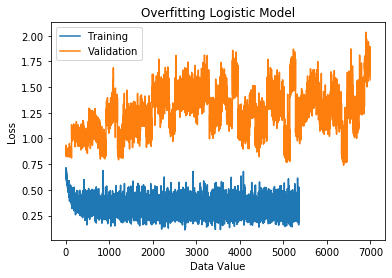

In [387]:
plt.xlabel("Data Value")
plt.ylabel("Loss")
plt.title("Overfitting Logistic Model")
plt.plot(t_losses,label="Training")
plt.plot(v_losses,label="Validation")
plt.legend()

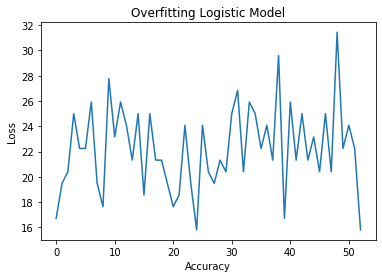

In [388]:
plt.xlabel("Accuracy")
plt.ylabel("Loss")
plt.title("Overfitting Logistic Model")
plt.plot(accuracies)

## Plot ROC curve to understand overfit model

AUROC: 0.979


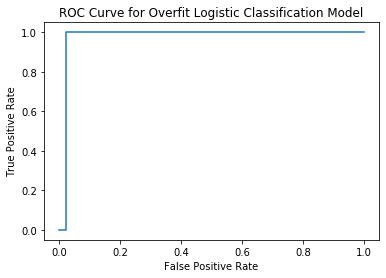

In [389]:
import sklearn.metrics as metrics
fpr, tpr, _ = metrics.roc_curve(Y_v.detach().numpy(), Y_v_hat.detach().numpy())
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Overfit Logistic Classification Model")
plt.plot(fpr, tpr)
print ("AUROC: {0:.3f}".format(metrics.roc_auc_score(Y_v.detach().numpy(), Y_v_hat.detach().numpy())))

## Try with FFNN, but still overfit

In [390]:
hidden_dim = 100
model = FFNN(input_dim, hidden_dim, act_fn="relu", apply_dropout=False)
model

FFNN(
  (fc1): Linear(in_features=26, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
)

In [399]:
accuracies = []
t_losses = []
v_losses = []
Y_v, Y_v_hat = train_model(model, epochs, learning_rate = 0.01)

Iteration: 100. Training Loss: 0.10454200953245163. Validation Loss: 2.9471404552459717. Accuracy: 21.32
Iteration: 200. Training Loss: 0.18108293414115906. Validation Loss: 2.0491580963134766. Accuracy: 17.64
Iteration: 300. Training Loss: 0.03146582096815109. Validation Loss: 3.5434093475341797. Accuracy: 24.08
Iteration: 400. Training Loss: 0.12756676971912384. Validation Loss: 2.998819351196289. Accuracy: 21.32
Iteration: 500. Training Loss: 0.09224696457386017. Validation Loss: 5.38564920425415. Accuracy: 26.84
Iteration: 600. Training Loss: 0.2586812376976013. Validation Loss: 2.9955883026123047. Accuracy: 21.32
Iteration: 700. Training Loss: 0.026013776659965515. Validation Loss: 2.3700363636016846. Accuracy: 25.0
Iteration: 800. Training Loss: 0.1680801808834076. Validation Loss: 2.642704963684082. Accuracy: 26.84
Iteration: 900. Training Loss: 0.13930168747901917. Validation Loss: 6.604023456573486. Accuracy: 26.84
Iteration: 1000. Training Loss: 0.1162886917591095. Validation

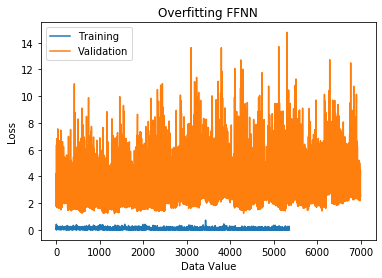

In [400]:
plt.xlabel("Data Value")
plt.ylabel("Loss")
plt.title("Overfitting FFNN")
plt.plot(t_losses,label="Training")
plt.plot(v_losses,label="Validation")
plt.legend()

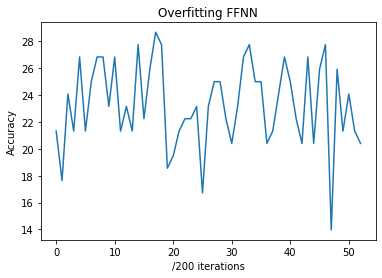

In [401]:
plt.xlabel("/200 iterations")
plt.ylabel("Accuracy")
plt.title("Overfitting FFNN")
plt.plot(accuracies)

AUROC: 0.993


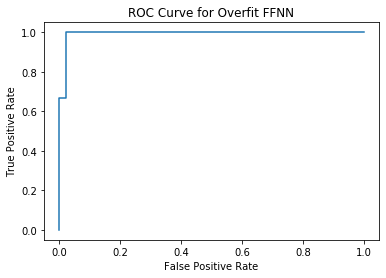

In [402]:
fpr, tpr, _ = metrics.roc_curve(Y_v.detach().numpy(), Y_v_hat.detach().numpy())
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Overfit FFNN")
plt.plot(fpr, tpr)
print ("AUROC: {0:.3f}".format(metrics.roc_auc_score(Y_v.detach().numpy(), Y_v_hat.detach().numpy())))

In [395]:
model2 = FFNN(input_dim, 100, act_fn="relu", apply_dropout=True)
accuracies = []
t_losses = []
v_losses = []
Y_v, Y_v_hat = train_model(model2, epochs,learning_rate=0.01)

Iteration: 100. Training Loss: 0.35071370005607605. Validation Loss: 1.1294195652008057. Accuracy: 22.24
Iteration: 200. Training Loss: 0.19181889295578003. Validation Loss: 1.0289521217346191. Accuracy: 21.32
Iteration: 300. Training Loss: 0.153578981757164. Validation Loss: 1.3879214525222778. Accuracy: 21.32
Iteration: 400. Training Loss: 0.30113470554351807. Validation Loss: 1.6547106504440308. Accuracy: 16.72
Iteration: 500. Training Loss: 0.268002986907959. Validation Loss: 1.3876070976257324. Accuracy: 22.24
Iteration: 600. Training Loss: 0.20210036635398865. Validation Loss: 1.5799648761749268. Accuracy: 24.08
Iteration: 700. Training Loss: 0.2165616750717163. Validation Loss: 1.2293024063110352. Accuracy: 23.16
Iteration: 800. Training Loss: 0.15581899881362915. Validation Loss: 1.2255128622055054. Accuracy: 18.56
Iteration: 900. Training Loss: 0.16512945294380188. Validation Loss: 2.181326389312744. Accuracy: 23.16
Iteration: 1000. Training Loss: 0.195235475897789. Validation

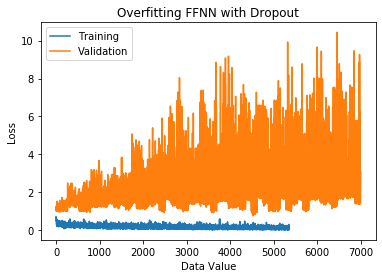

In [396]:
plt.xlabel("Data Value")
plt.ylabel("Loss")
plt.title("Overfitting FFNN with Dropout")
plt.plot(t_losses,label="Training")
plt.plot(v_losses,label="Validation")
plt.legend()

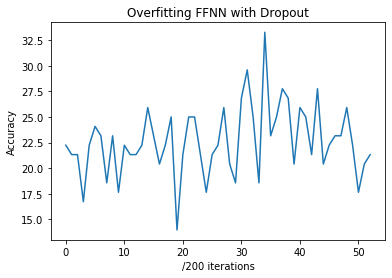

In [397]:
plt.xlabel("/200 iterations")
plt.ylabel("Accuracy")
plt.title("Overfitting FFNN with Dropout")
plt.plot(accuracies)

AUROC: 0.979


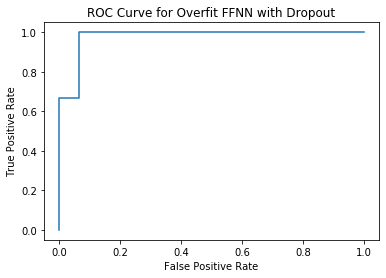

In [398]:
fpr, tpr, _ = metrics.roc_curve(Y_v.detach().numpy(), Y_v_hat.detach().numpy())
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Overfit FFNN with Dropout")
plt.plot(fpr, tpr)
print ("AUROC: {0:.3f}".format(metrics.roc_auc_score(Y_v.detach().numpy(), Y_v_hat.detach().numpy())))